<a href="https://colab.research.google.com/github/idris-135/ensemble/blob/main/Ensemble_220924.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Parameters
SPLIT = .8 # @param {type:"slider", min:0.1, max:1, step:0.05}
TIMESERIES_RESOLUTION = "15min" # @param {type:"string"}
SEQUENCE_LEN = 7 # @param {type:"integer"}
max_P = 1 # @param {type:"integer"}
max_Q = 1 # @param {type:"integer"}
maxiter=200 # @param {type:"integer"}

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 12.7 MB/s eta 0:00:00


## Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Libraries for ARIMA Models
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

#Libraries for LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

# Import the RandomForestRegressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor


### Load Data

In [ ]:
# Load the power usage and weather data
power_data = pd.read_csv('/content/power_usage_2016_to_2020.csv')
weather_data = pd.read_csv('/content/weather_2016_2020_daily.csv')

In [ ]:
power_data_info = power_data.info()
weather_info = weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    35952 non-null  object 
 1   Value (kWh)  35952 non-null  float64
 2   day_of_week  35952 non-null  int64  
 3   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1552 non-null   object 
 1   Day          1552 non-null   int64  
 2   Temp_max     1552 non-null   int64  
 3   Temp_avg     1552 non-null   float64
 4   Temp_min     1552 non-null   int64  
 5   Dew_max      1552 non-null   int64  
 6   Dew_avg      1552 non-null   float64
 7   Dew_min      1552 non-null   int64  
 8   Hum_max      1552 non-null   int64  
 9   Hum_

### Convert Date as Object to Date Time and Merge Both Data Set

In [ ]:
# Convert the 'StartDate' and 'Date' columns to datetime format
power_data['StartDate'] = pd.to_datetime(power_data['StartDate'])
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

# Merge the datasets on the date
merged_data = pd.merge(power_data, weather_data, left_on='StartDate', right_on='Date')

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   StartDate      1498 non-null   datetime64[ns]
 1   Value (kWh)    1498 non-null   float64       
 2   day_of_week_x  1498 non-null   int64         
 3   notes          1498 non-null   object        
 4   Date           1498 non-null   datetime64[ns]
 5   Day            1498 non-null   int64         
 6   Temp_max       1498 non-null   int64         
 7   Temp_avg       1498 non-null   float64       
 8   Temp_min       1498 non-null   int64         
 9   Dew_max        1498 non-null   int64         
 10  Dew_avg        1498 non-null   float64       
 11  Dew_min        1498 non-null   int64         
 12  Hum_max        1498 non-null   int64         
 13  Hum_avg        1498 non-null   float64       
 14  Hum_min        1498 non-null   int64         
 15  Wind_max       1498 n

### Handle Missing Values

In [ ]:
missing_values = merged_data.isnull().sum()
missing_values

,0
StartDate,0
Value (kWh),0
day_of_week_x,0
notes,0
Date,0
Day,0
Temp_max,0
Temp_avg,0
Temp_min,0
Dew_max,0


###Generate summary statistics for the combined dataset

In [ ]:
summary_statistics = merged_data.describe()
summary_statistics.to_csv('summary_raw.csv', index=False)
summary_statistics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, count to std
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   StartDate      7 non-null      object 
 1   Value (kWh)    8 non-null      float64
 2   day_of_week_x  8 non-null      float64
 3   Date           7 non-null      object 
 4   Day            8 non-null      float64
 5   Temp_max       8 non-null      float64
 6   Temp_avg       8 non-null      float64
 7   Temp_min       8 non-null      float64
 8   Dew_max        8 non-null      float64
 9   Dew_avg        8 non-null      float64
 10  Dew_min        8 non-null      float64
 11  Hum_max        8 non-null      float64
 12  Hum_avg        8 non-null      float64
 13  Hum_min        8 non-null      float64
 14  Wind_max       8 non-null      float64
 15  Wind_avg       8 non-null      float64
 16  Wind_min       8 non-null      float64
 17  Press_max      8 non-null      float64
 18  Press_avg    

###Generate Distribution Plot.

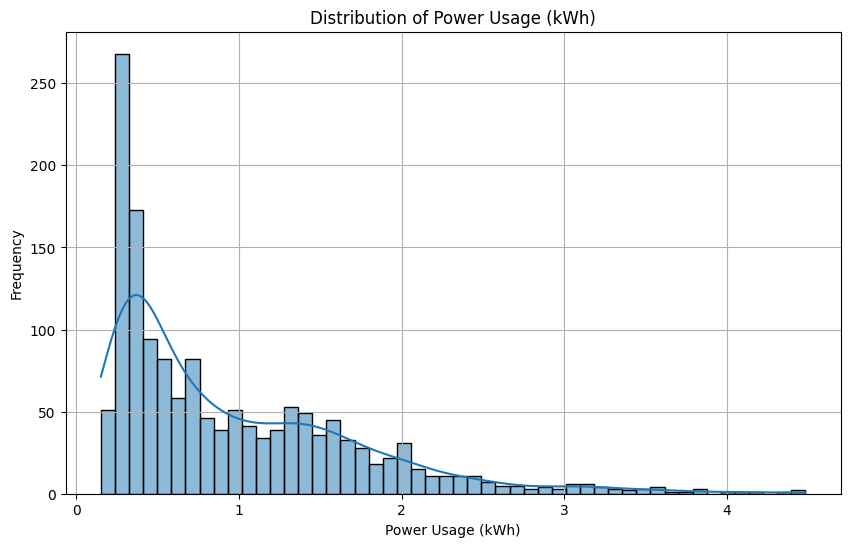

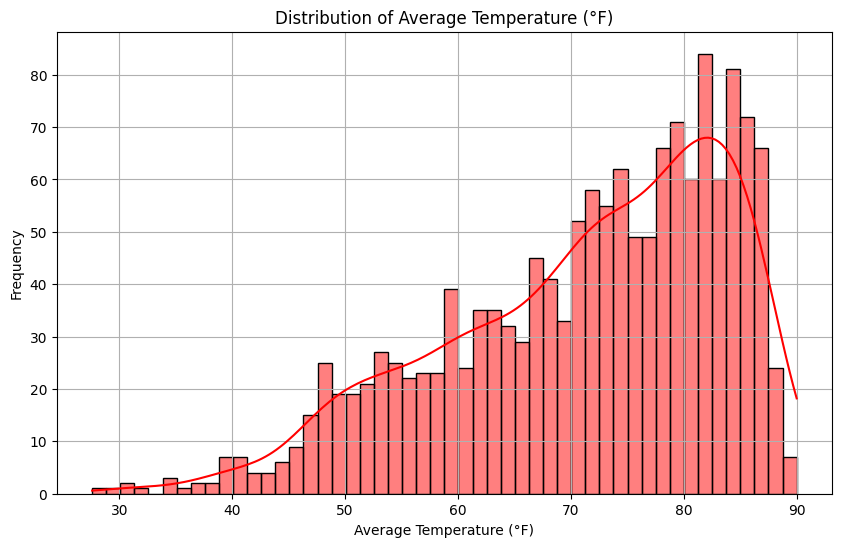

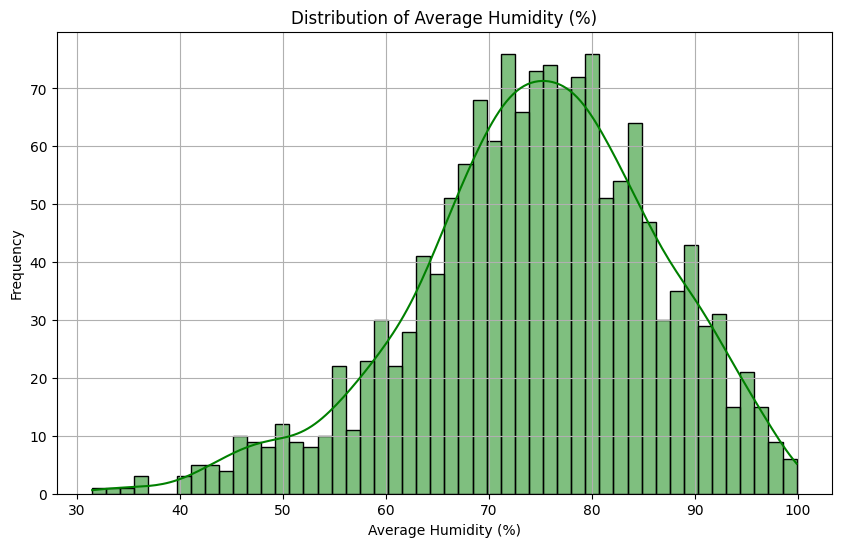

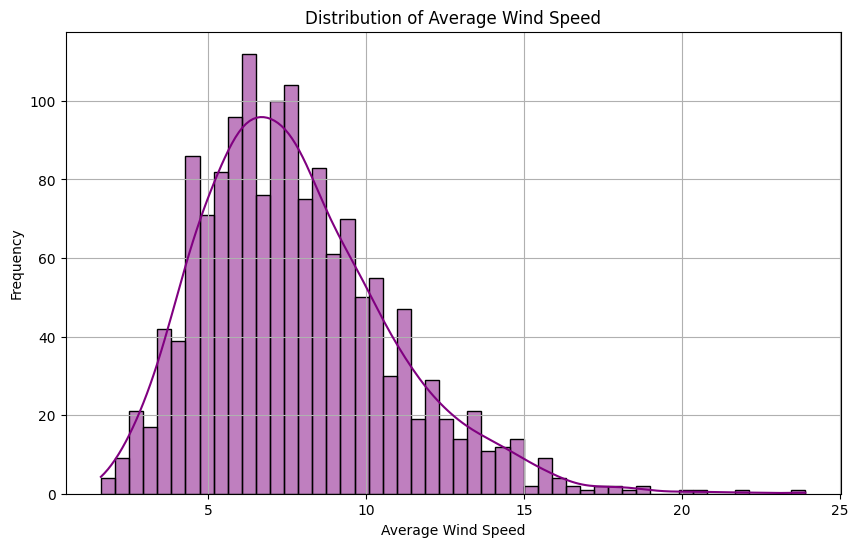

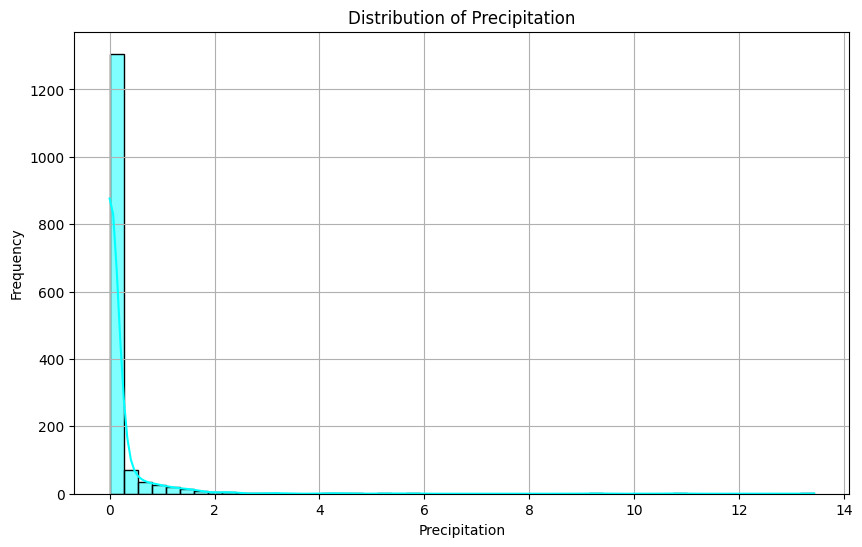

In [ ]:
# Distribution plot for Power Usage
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['Value (kWh)'], bins=50, kde=True)
plt.title('Distribution of Power Usage (kWh)')
plt.xlabel('Power Usage (kWh)')
plt.ylabel('Frequency')
plt.grid(True)
#plt.show()
plt.savefig('power_usage_dis.png', dpi=300, bbox_inches='tight')

# Distribution plot for Average Temperature
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['Temp_avg'], bins=50, kde=True, color='red')
plt.title('Distribution of Average Temperature (°F)')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
#plt.show()
plt.savefig('temp_avg_dis.png', dpi=300, bbox_inches='tight')

# Distribution plot for Average Humidity
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['Hum_avg'], bins=50, kde=True, color='green')
plt.title('Distribution of Average Humidity (%)')
plt.xlabel('Average Humidity (%)')
plt.ylabel('Frequency')
plt.grid(True)
#plt.show()
plt.savefig('hum_avg_dis.png', dpi=300, bbox_inches='tight')

# Distribution plot for Average Wind Speed
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['Wind_avg'], bins=50, kde=True, color='purple')
plt.title('Distribution of Average Wind Speed')
plt.xlabel('Average Wind Speed')
plt.ylabel('Frequency')
plt.grid(True)
#plt.show()
plt.savefig('wind_avg_dis.png', dpi=300, bbox_inches='tight')

# Distribution plot for Precipitation
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['Precipit'], bins=50, kde=True, color='cyan')
plt.title('Distribution of Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.grid(True)
#plt.show()
plt.savefig('prep_avg_dis.png', dpi=300, bbox_inches='tight')

## Corelation Matrix

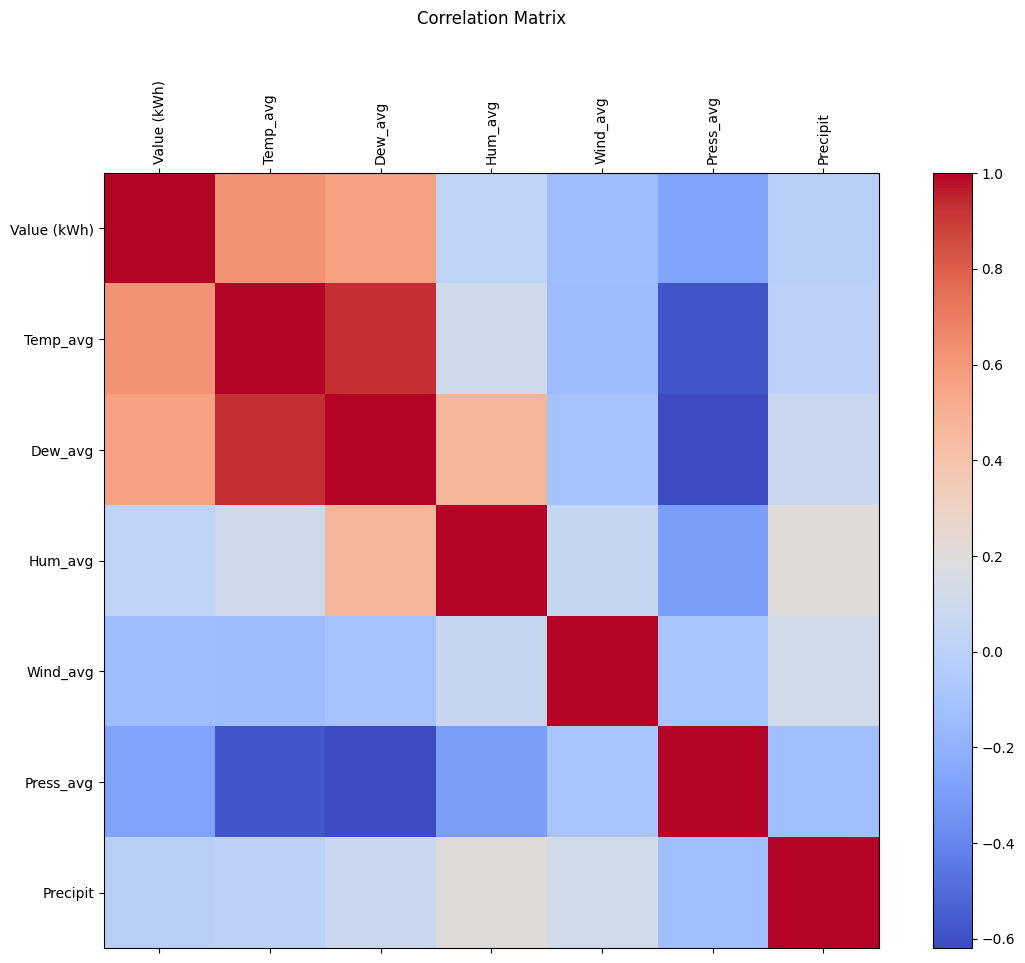

In [ ]:
# Create a correlation matrix
correlation_matrix = merged_data[['Value (kWh)', 'Temp_avg', 'Dew_avg',  'Hum_avg', 'Wind_avg',
                                  'Press_avg',  'Precipit']].corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 10))
plt.matshow(correlation_matrix, fignum=1, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(correlation_matrix.shape[1]), correlation_matrix.columns, rotation=90)
plt.yticks(range(correlation_matrix.shape[1]), correlation_matrix.columns)
plt.title('Correlation Matrix', pad=40)
#plt.show()
plt.savefig('correlation.png', dpi=300, bbox_inches='tight')

### Aggregate power usage data by month

In [ ]:
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Year'] = merged_data['Date'].dt.year
monthly_power_usage = merged_data.groupby(['Year', 'Month'])['Value (kWh)'].sum().reset_index()
monthly_power_usage.head()

,Year,Month,Value (kWh)
0,2016,1,8.288
1,2016,2,8.452
2,2016,3,7.043
3,2016,4,8.576
4,2016,5,7.461


In [ ]:
# Pivot the data to have years as columns and months as rows
monthly_power_usage_pivot = monthly_power_usage.pivot(index='Month', columns='Year', values='Value (kWh)')
monthly_power_usage_pivot.head()

Year,2016,2017,2018,2019,2020
Month,,,,,
1,8.288,17.325,16.8540,16.59000,12.474
2,8.452,14.561,20.3134,16.85700,12.407
3,7.043,21.649,29.8629,19.53348,17.063
4,8.576,20.883,24.4520,26.13000,14.313
5,7.461,29.683,41.9380,30.30300,28.351


### Plot Yearly power Usage

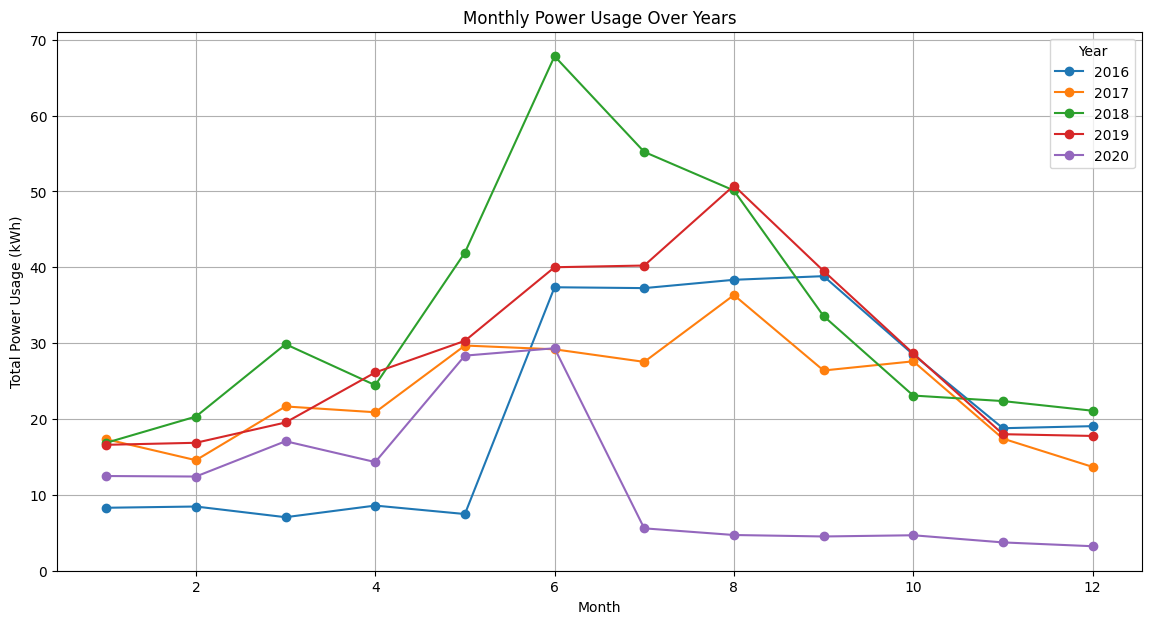

In [ ]:
# Plot power usage yearly
plt.figure(figsize=(14, 7))
for year in monthly_power_usage_pivot.columns:
    plt.plot(monthly_power_usage_pivot.index, monthly_power_usage_pivot[year], marker='o', label=year)
plt.title('Monthly Power Usage Over Years')
plt.xlabel('Month')
plt.ylabel('Total Power Usage (kWh)')
plt.legend(title='Year')
plt.grid(True)
#plt.show()
plt.savefig('yearly_usage.png', dpi=300, bbox_inches='tight')

### Analyze Trend, Seasonality, Cyclicity, and Noise.

In [ ]:
# Decompose the time series into trend, seasonal, cyclical, and irregular components
daily_power_usage = merged_data.resample('D', on='StartDate')['Value (kWh)'].sum()
decomposition = seasonal_decompose(daily_power_usage, model='additive')

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
irregular = decomposition.resid

### Plot the components

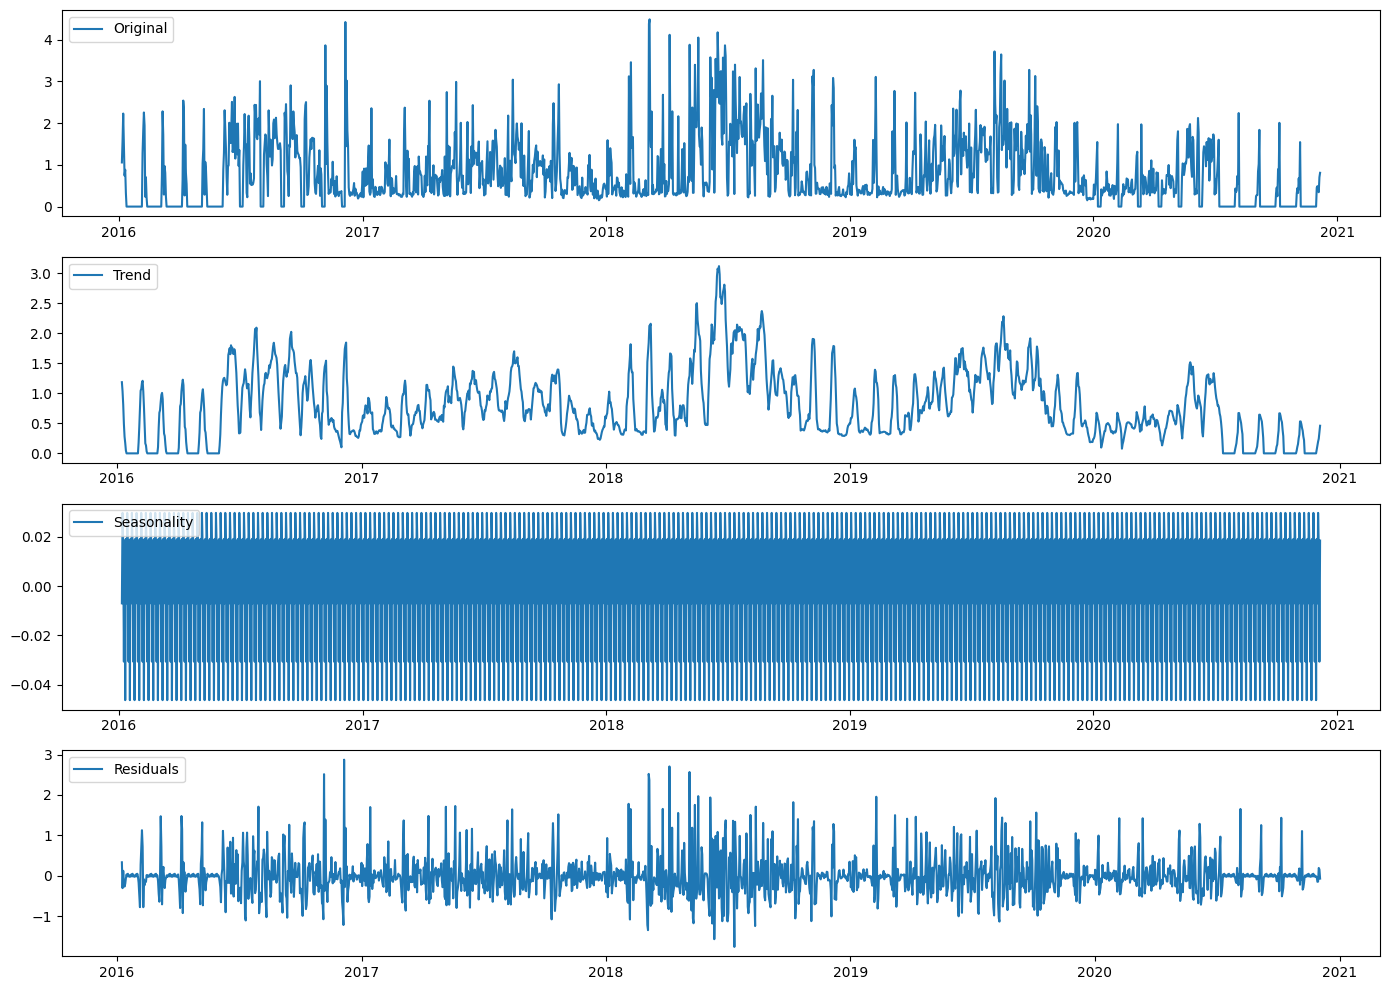

In [ ]:
# Plot the components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(daily_power_usage, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(irregular, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.show()
plt.savefig('decompose.png', dpi=300, bbox_inches='tight')

### Analyze Stationary using ADF

In [ ]:
#using ADF
# Test for stationarity
result_original = adfuller(daily_power_usage)
# Difference the time series and plot
diff_data = daily_power_usage.diff().dropna()
result_diff = adfuller(diff_data)


# Prepare the ADF test results for saving to CSV
adf_results = {
    'Test': ['Original Time Series', 'Differenced Time Series'],
    'ADF Statistic': [result_original[0], result_diff[0]],
    'p-value': [result_original[1], result_diff[1]],
    'Critical Value (1%)': [result_original[4]['1%'], result_diff[4]['1%']],
    'Critical Value (5%)': [result_original[4]['5%'], result_diff[4]['5%']],
    'Critical Value (10%)': [result_original[4]['10%'], result_diff[4]['10%']]
}

adf_results_df = pd.DataFrame(adf_results)

# Save the ADF test results to CSV
adf_results_df.to_csv('adf_test_results.csv', index=False)


### Analyze Stationary using KPSS

In [ ]:
kpss_result_original = kpss(daily_power_usage, regression='c')
kpss_result_diff = kpss(diff_data, regression='c')

# Prepare the ADF test results for saving to CSV
kpss_results = {
    'Test': ['Original Time Series', 'Differenced Time Series'],
    'KPSS Statistic': [kpss_result_original[0], kpss_result_diff[0]],
    'p-value': [kpss_result_original[1], kpss_result_diff[1]],
    'Critical Value (1%)': [kpss_result_original[3]['1%'], kpss_result_diff[3]['1%']],
    'Critical Value (2.5%)': [kpss_result_original[3]['2.5%'], kpss_result_diff[3]['2.5%']],
    'Critical Value (5%)': [kpss_result_original[3]['5%'], kpss_result_diff[3]['5%']],
    'Critical Value (10%)': [kpss_result_original[3]['10%'], kpss_result_diff[3]['10%']]
}

kpss_results_df = pd.DataFrame(kpss_results)

# Save the ADF test results to CSV
kpss_results_df.to_csv('kpss_test_results.csv', index=False)

### Analyze ACF and PACF

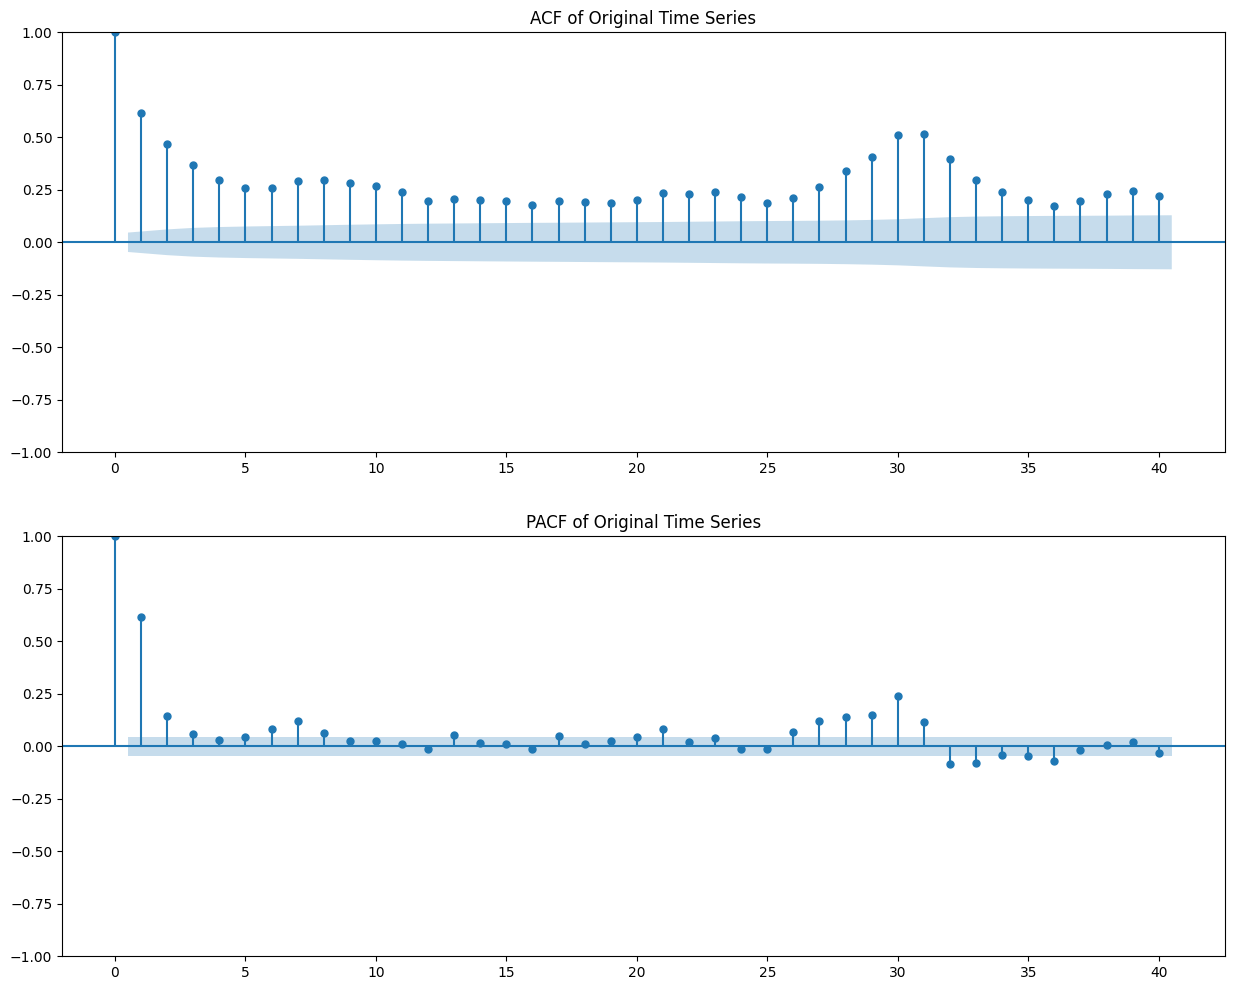

In [ ]:
# Plot ACF and PACF for the original time series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
plot_acf(daily_power_usage, lags=40, ax=ax1)
plot_pacf(daily_power_usage, lags=40, ax=ax2)
ax1.set_title('ACF of Original Time Series')
ax2.set_title('PACF of Original Time Series')
#plt.show()
plt.savefig('acf_pacf.png', dpi=300, bbox_inches='tight')

#### Feature Engineering

In [ ]:
# Resample the power usage data to set frequency
sample_data = power_data.set_index('StartDate')['Value (kWh)'].resample(TIMESERIES_RESOLUTION).sum().reset_index()
# Merge the sampledata on the date
combined_df = pd.merge(sample_data, weather_data, left_on='StartDate', right_on='Date')



In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   StartDate    1550 non-null   datetime64[ns]
 1   Value (kWh)  1550 non-null   float64       
 2   Date         1550 non-null   datetime64[ns]
 3   Day          1550 non-null   int64         
 4   Temp_max     1550 non-null   int64         
 5   Temp_avg     1550 non-null   float64       
 6   Temp_min     1550 non-null   int64         
 7   Dew_max      1550 non-null   int64         
 8   Dew_avg      1550 non-null   float64       
 9   Dew_min      1550 non-null   int64         
 10  Hum_max      1550 non-null   int64         
 11  Hum_avg      1550 non-null   float64       
 12  Hum_min      1550 non-null   int64         
 13  Wind_max     1550 non-null   int64         
 14  Wind_avg     1550 non-null   float64       
 15  Wind_min     1550 non-null   int64         
 16  Press_

In [ ]:

# Feature Engineering: Lagged features, rolling statistics, interaction terms
combined_df['lag_1'] = combined_df['Value (kWh)'].shift(1)
combined_df['lag_7'] = combined_df['Value (kWh)'].shift(7)
combined_df['rolling_mean_7'] = combined_df['Value (kWh)'].rolling(window=7).mean()
combined_df['rolling_std_7'] = combined_df['Value (kWh)'].rolling(window=7).std()
combined_df['temp_hum_interaction'] = combined_df['Temp_avg'] * combined_df['Hum_avg']
combined_df['wind_press_interaction'] = combined_df['Wind_avg'] * combined_df['Press_avg']

# Encode cyclical features (day of week)
combined_df['day_of_week_sin'] = np.sin(2 * np.pi * combined_df['Date'].dt.dayofweek / 7)
combined_df['day_of_week_cos'] = np.cos(2 * np.pi * combined_df['Date'].dt.dayofweek / 7)

# Add US Federal Holidays feature
cal = calendar()
holidays = cal.holidays(start=combined_df['Date'].min(), end=combined_df['Date'].max())
combined_df['holiday'] = combined_df['Date'].isin(holidays).astype(int)

# Add previous year's data as features
combined_df['lag_365'] = combined_df['Value (kWh)'].shift(365)
combined_df['lag_364'] = combined_df['Value (kWh)'].shift(364)  # Day before last year
combined_df['lag_366'] = combined_df['Value (kWh)'].shift(366)  # Day after last year

# Drop missing values created by lagging and rolling calculations
combined_df = combined_df.dropna()


In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1184 entries, 366 to 1549
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   StartDate               1184 non-null   datetime64[ns]
 1   Value (kWh)             1184 non-null   float64       
 2   Date                    1184 non-null   datetime64[ns]
 3   Day                     1184 non-null   int64         
 4   Temp_max                1184 non-null   int64         
 5   Temp_avg                1184 non-null   float64       
 6   Temp_min                1184 non-null   int64         
 7   Dew_max                 1184 non-null   int64         
 8   Dew_avg                 1184 non-null   float64       
 9   Dew_min                 1184 non-null   int64         
 10  Hum_max                 1184 non-null   int64         
 11  Hum_avg                 1184 non-null   float64       
 12  Hum_min                 1184 non-null   int64      

In [ ]:
# Define the numerical features for ARIMA Model to be standardized
features_arima = ['Value (kWh)', 'Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg', 'Dew_min',
                      'Hum_max', 'Hum_avg', 'Hum_min', 'Wind_max', 'Wind_avg', 'Wind_min',
                      'Press_max', 'Press_avg', 'Press_min', 'Precipit', 'lag_1', 'lag_7',
                      'rolling_mean_7', 'rolling_std_7', 'temp_hum_interaction', 'wind_press_interaction',
                      'lag_364', 'lag_365', 'lag_366'] # Include lagged year features

# Selecting relevant features for LSTM model to be standardized
features_lstm = ['Value (kWh)', 'Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max',
            'Dew_avg', 'Dew_min', 'Hum_max', 'Hum_avg', 'Hum_min',
            'Wind_max', 'Wind_avg', 'Wind_min', 'Press_max', 'Press_avg', 'Press_min', 'Precipit']

In [ ]:
# Split the dataset based on percentage (e.g., 80% train, 20% test)
train_size = int(len(combined_df) * SPLIT)
train_data = combined_df[:train_size]
test_data = combined_df[train_size:]


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Standardize the training and testing sets
train_data[features_arima] = scaler.fit_transform(train_data[features_arima])
test_data[features_arima] = scaler.transform(test_data[features_arima])

In [ ]:
# Define the exogenous variables
exog_vars_train = train_data.drop(columns=['Date', 'StartDate', 'Day', 'day_of_week'])
exog_vars_test = test_data.drop(columns=['Date', 'StartDate', 'Day', 'day_of_week'])

# Find the best ARIMA model using auto_arima (adjust parameters as needed)
auto_model = auto_arima(train_data['Value (kWh)'], exogenous=exog_vars_train, seasonal=True, m=7,
                        stepwise=False, trace=True, error_action='ignore', suppress_warnings=True,
                        D=1, # Enforce first-order seasonal differencing
                        max_P=5, max_Q=5, # Limit complexity of seasonal components
                        maxiter=200) # Increase iterations for better convergence

# Fit the best model
ARIMA_model = auto_model.fit(train_data['Value (kWh)'], exogenous=exog_vars_train)

# Test the model on the testing data
y_pred_arima = ARIMA_model.predict(n_periods=len(test_data), exogenous=exog_vars_test)

# Calculate MAE, MSE, and RMSE for the testing dataset
mae_arima = mean_absolute_error(test_data['Value (kWh)'], y_pred_arima)
mse_arima = mean_squared_error(test_data['Value (kWh)'], y_pred_arima)
rmse_arima = np.sqrt(mse_arima)

print(f"Best ARIMA Model: {auto_model.order}")
print(f"MAE: {mae_arima}")
print(f"MSE: {mse_arima}")
print(f"RMSE: {rmse_arima}")

 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3068.144, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=2624.244, Time=0.34 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=2625.448, Time=0.61 sec
 ARIMA(0,0,0)(0,1,3)[7] intercept   : AIC=2618.304, Time=2.37 sec
 ARIMA(0,0,0)(0,1,4)[7] intercept   : AIC=2614.129, Time=2.55 sec
 ARIMA(0,0,0)(0,1,5)[7] intercept   : AIC=2598.732, Time=4.45 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=2879.744, Time=0.19 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=2625.652, Time=0.41 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=2626.169, Time=1.13 sec
 ARIMA(0,0,0)(1,1,3)[7] intercept   : AIC=2618.673, Time=2.61 sec
 ARIMA(0,0,0)(1,1,4)[7] intercept   : AIC=2604.259, Time=3.00 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=2764.240, Time=0.51 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=2615.687, Time=0.75 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : AIC=2614.953, Time=1.27 sec
 ARIMA(0,0,0)(2,1,3)[7] intercept   : AIC=inf, Time=15.38 sec
 ARIMA(0,0,0)(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


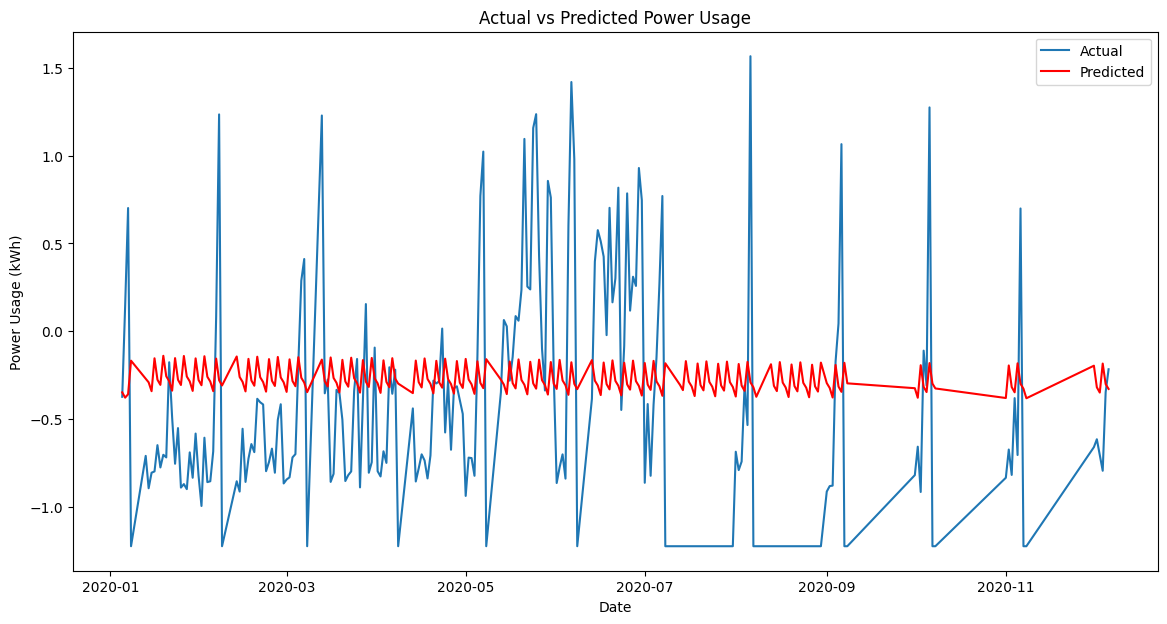

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_data['Date'], test_data['Value (kWh)'], label='Actual')
plt.plot(test_data['Date'], y_pred_arima, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Power Usage (kWh)')
plt.title('Actual vs Predicted Power Usage')
plt.legend()
plt.show()

In [ ]:
# Prepare the data for LSTM: Creating sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Target is the next power usage value
    return np.array(X), np.array(y)


In [ ]:
# Initialize the scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_df[features_lstm])

In [ ]:
# Create sequences for LSTM input
X, y = create_sequences(scaled_data, SEQUENCE_LEN)

In [ ]:
# Split the data into training and testing sets (80-20 split)
split_index = int(SPLIT * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((941, 7, 17), (236, 7, 17), (941,), (236,))

In [ ]:

# Define the LSTM model with L2 regularization
model_lstm = Sequential()
model_lstm.add(LSTM(units=1000, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
                    kernel_regularizer=l2(0.001)))  # Adding L2 regularization
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=500, return_sequences=False, kernel_regularizer=l2(0.001)))  # Adding L2 regularization
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_lstm = model_lstm.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2,
                              callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred_lstm = model_lstm.predict(X_test)

# Calculate evaluation metrics
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)

print(f"MAE: {mae_lstm}")
print(f"MSE: {mse_lstm}")
print(f"RMSE: {rmse_lstm}")

model_lstm.summary()

Epoch 1/5
24/24 [==============================] - 6s 128ms/step - loss: 1.8067 - val_loss: 1.1176
Epoch 2/5
24/24 [==============================] - 2s 94ms/step - loss: 1.1210 - val_loss: 0.8877
Epoch 3/5
24/24 [==============================] - 2s 96ms/step - loss: 0.9212 - val_loss: 0.7593
Epoch 4/5
24/24 [==============================] - 2s 96ms/step - loss: 0.8861 - val_loss: 0.6985
Epoch 5/5
8/8 [==============================] - 1s 27ms/step
MAE: 0.5294266393660093
MSE: 0.4739762201923128
RMSE: 0.6884593090316324
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 1000)           4072000   
                                                                 
 dropout (Dropout)           (None, 7, 1000)           0         
                                                                 
 lstm_1 (LSTM)               (None, 500)               3

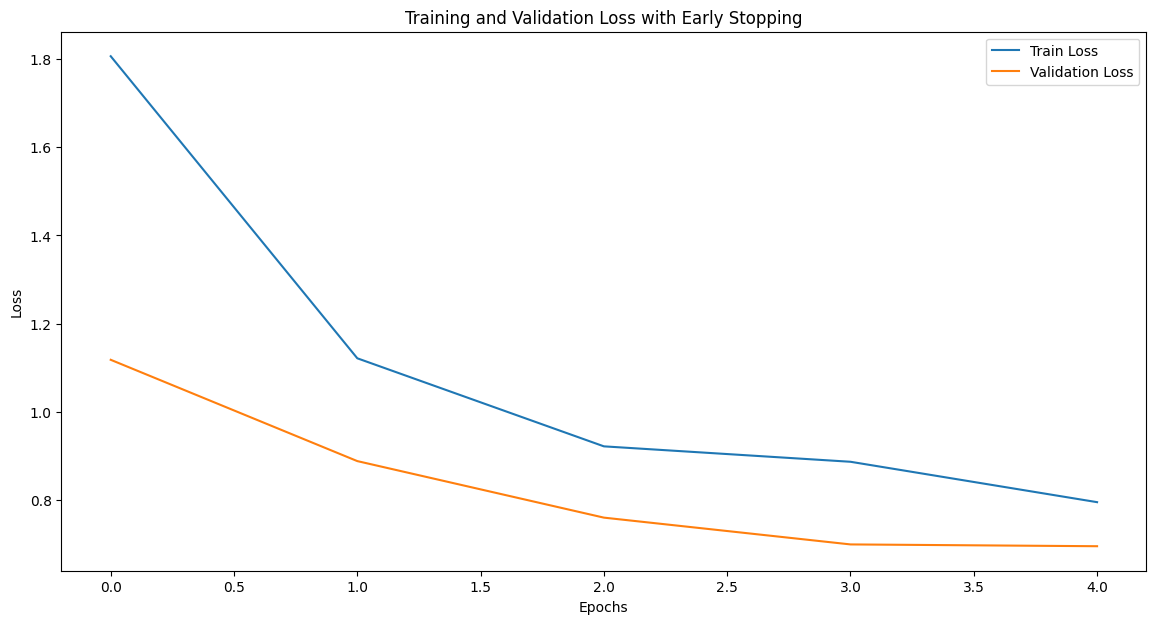

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

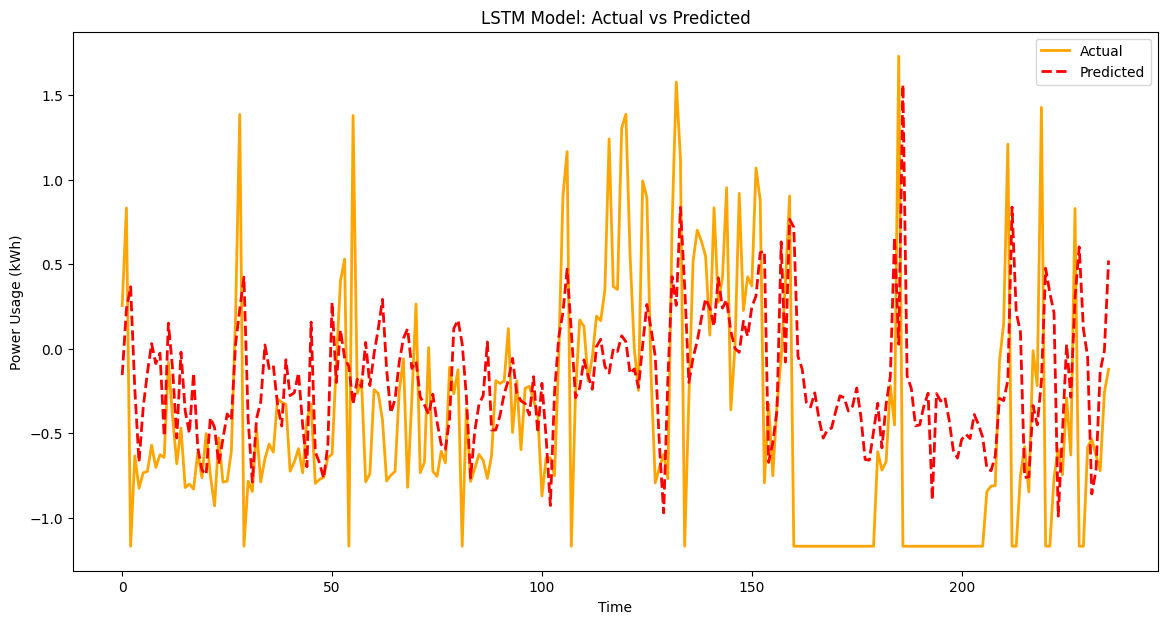

In [ ]:
# Reshape predictions if necessary (depends on LSTM output shape)
#y_pred_lstm = y_pred_lstm.flatten()  # Flatten if it's a column vector

# Plotting the true vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual', color='orange', linewidth=2)
plt.plot(y_pred_lstm, label='Predicted', color='red', linestyle='dashed', linewidth=2)

# Title and labels
plt.title('LSTM Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Power Usage (kWh)')
plt.legend()

plt.show()


In [ ]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# Define the objective function that calculates MSE for given weights
def mse_loss(weights, y_pred_arima, y_pred_lstm, y_test):
    weight_arima, weight_lstm = weights
    # Normalize weights to sum to 1
    weight_arima = weight_arima / (weight_arima + weight_lstm)
    weight_lstm = 1 - weight_arima
    # Ensure weights are non-negative
    weight_arima = max(weight_arima, 0)
    weight_lstm = max(weight_lstm, 0)

    # Truncate the longer array
    min_length = min(len(y_pred_arima), len(y_pred_lstm.flatten()))

    # Ensemble prediction using current weights
    ensemble_predictions = (weight_arima * y_pred_arima[:min_length]) + (weight_lstm * y_pred_lstm.flatten()[:min_length])

    # Calculate MSE
    mse = mean_squared_error(y_test[:min_length], ensemble_predictions)
    return mse

# Initial guess for weights
initial_weights = [0.5, 0.5]

# Optimize weights
result = minimize(mse_loss, initial_weights, args=(y_pred_arima, y_pred_lstm, y_test), bounds=[(0, 1), (0, 1)], method='SLSQP')

# Extract optimal weights
optimal_weight_arima, optimal_weight_lstm = result.x
# Normalize the weights
optimal_weight_arima = optimal_weight_arima / (optimal_weight_arima + optimal_weight_lstm)
optimal_weight_lstm = 1 - optimal_weight_arima

print(f"Optimal Weight for ARIMA: {optimal_weight_arima}")
print(f"Optimal Weight for LSTM: {optimal_weight_lstm}")

# Use optimal weights for ensemble predictions
min_length = min(len(y_pred_arima), len(y_pred_lstm.flatten()))
ensemble_predictions = (optimal_weight_arima * y_pred_arima[:min_length]) + (optimal_weight_lstm * y_pred_lstm.flatten()[:min_length])

# Evaluate ensemble performance
ensemble_mae = mean_absolute_error(y_test[:min_length], ensemble_predictions)
ensemble_mse = mean_squared_error(y_test[:min_length], ensemble_predictions)
ensemble_rmse = np.sqrt(ensemble_mse)

print(f" MAE: {ensemble_mae}")
print(f" MSE: {ensemble_mse}")
print(f" RMSE: {ensemble_rmse}")


Optimal Weight for ARIMA: 0.5000126054513404
Optimal Weight for LSTM: 0.4999873945486596
 MAE: 0.5369280804320886
 MSE: 0.4428214931584054
 RMSE: 0.6654483399621682


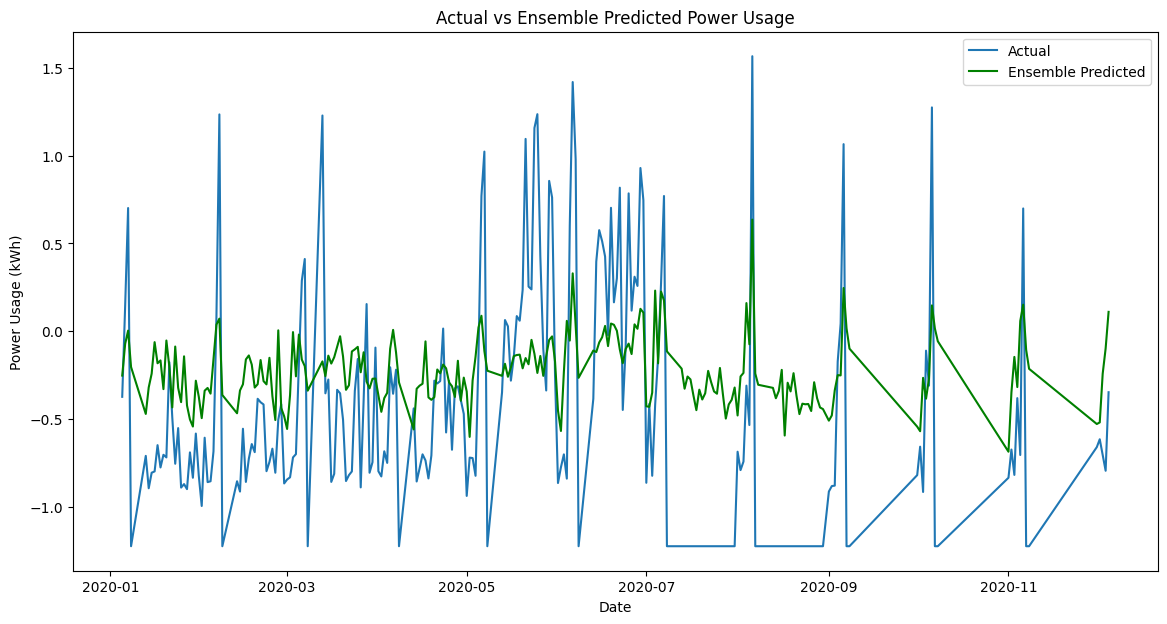

In [ ]:
# Plotting ensemble results
plt.figure(figsize=(14, 7))
plt.plot(test_data['Date'][:min_length], test_data['Value (kWh)'][:min_length], label='Actual')
plt.plot(test_data['Date'][:min_length], ensemble_predictions, label='Ensemble Predicted', color='green')
plt.xlabel('Date')
plt.ylabel('Power Usage (kWh)')
plt.title('Actual vs Ensemble Predicted Power Usage')
plt.legend()
plt.show()